# Week 9 Centrograph Group Assignment

The first notebook of our group assignment focuses on the housing data with the spatially statistic analysis. And this notebook continue that tests and apply the strategies with the commuting data.

Specifically, in this note, I will be seeing how the commuters change spatially by mapping out where they are and how much population each census tract has withint NY metro region. Then, I also use mean, median, and standard ellipse to see the statistic results of all data.

In [1]:
# Import all modules

import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import folium
from geopandas import GeoDataFrame
from shapely.geometry import Point
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
from sodapy import Socrata
import seaborn as sns
from pointpats import centrography
from matplotlib.patches import Ellipse

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Prepare Data Set

The NY metro includes four states, but all states have seperate geodata. I will first combine all states togehter and then select those where are within the NY metro region.

In [2]:
# Import all geo-data for all four states

tract_CT = gpd.read_file('Geodata/tract_09/cb_2017_09_tract_500k.shp')
tract_NJ = gpd.read_file('Geodata/tract_34/cb_2017_34_tract_500k.shp')
tract_NY = gpd.read_file('Geodata/tract_36/cb_2017_36_tract_500k.shp')
tract_PA = gpd.read_file('Geodata/tract_42/cb_2017_42_tract_500k.shp')

In [3]:
# Combine all four together

tract_NYMetro = pd.concat([tract_CT, tract_NJ,tract_NY,tract_PA])

In [4]:
# Take a look at the resulted dataframe

tract_NYMetro.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,09,001,010700,1400000US09001010700,09001010700,107,CT,1855241,87317,"POLYGON ((-73.62359 41.02190, -73.62381 41.022..."
1,09,001,022000,1400000US09001022000,09001022000,220,CT,736436,0,"POLYGON ((-73.52129 41.05514, -73.51671 41.055..."
2,09,001,042500,1400000US09001042500,09001042500,425,CT,6253007,38740,"POLYGON ((-73.42058 41.15837, -73.41898 41.160..."
3,09,001,043500,1400000US09001043500,09001043500,435,CT,1837183,0,"POLYGON ((-73.39860 41.11175, -73.39847 41.113..."
4,09,001,060100,1400000US09001060100,09001060100,601,CT,3985920,0,"POLYGON ((-73.25256 41.22666, -73.25135 41.230..."


In [5]:
# I have a CSV that contains the names for all census tracts within the NY metro region. I will use this as the base to filter.

NYMetro_Tract_NameList = pd.read_csv('Geodata/NYMetro_Tract_NameList.csv',
                                   dtype={
                                       'AFFGEOID':str
                                   }
                                   )

In [6]:
# Take a look at it.

NYMetro_Tract_NameList.head()

,AFFGEOID,Geographic Area Name
0,1400000US09001010101,"Census Tract 101.01, Fairfield County, Connect..."
1,1400000US09001010102,"Census Tract 101.02, Fairfield County, Connect..."
2,1400000US09001010201,"Census Tract 102.01, Fairfield County, Connect..."
3,1400000US09001010202,"Census Tract 102.02, Fairfield County, Connect..."
4,1400000US09001010300,"Census Tract 103, Fairfield County, Connecticut"


In [7]:
# Then, I will merge the name list and the four-state geodata so that I have a metro census tracts with geo-data

NYMetro_Tract_Geodata_Raw = tract_NYMetro.merge(NYMetro_Tract_NameList,
                                               on='AFFGEOID',
                                               how='right')

In [8]:
# Take a look at it. 

NYMetro_Tract_Geodata_Raw.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,Geographic Area Name
0,09,001,010700,1400000US09001010700,09001010700,107,CT,1855241.0,87317.0,"POLYGON ((-73.62359 41.02190, -73.62381 41.022...","Census Tract 107, Fairfield County, Connecticut"
1,09,001,022000,1400000US09001022000,09001022000,220,CT,736436.0,0.0,"POLYGON ((-73.52129 41.05514, -73.51671 41.055...","Census Tract 220, Fairfield County, Connecticut"
2,09,001,042500,1400000US09001042500,09001042500,425,CT,6253007.0,38740.0,"POLYGON ((-73.42058 41.15837, -73.41898 41.160...","Census Tract 425, Fairfield County, Connecticut"
3,09,001,043500,1400000US09001043500,09001043500,435,CT,1837183.0,0.0,"POLYGON ((-73.39860 41.11175, -73.39847 41.113...","Census Tract 435, Fairfield County, Connecticut"
4,09,001,060100,1400000US09001060100,09001060100,601,CT,3985920.0,0.0,"POLYGON ((-73.25256 41.22666, -73.25135 41.230...","Census Tract 601, Fairfield County, Connecticut"


In [9]:
# Make a new dataframe to put centroid points for each.

NYMetro_Tract_Geodata_Raw2 = NYMetro_Tract_Geodata_Raw

In [10]:
# Make all centroid points become the new geometry
NYMetro_Tract_Geodata_Raw.geometry = NYMetro_Tract_Geodata_Raw['geometry'].centroid

<ipython-input-10-5836032752a4>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  NYMetro_Tract_Geodata_Raw.geometry = NYMetro_Tract_Geodata_Raw['geometry'].centroid


In [11]:
# Take a look at it.

NYMetro_Tract_Geodata_Raw.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,Geographic Area Name
0,09,001,010700,1400000US09001010700,09001010700,107,CT,1855241.0,87317.0,POINT (-73.61489 41.03020),"Census Tract 107, Fairfield County, Connecticut"
1,09,001,022000,1400000US09001022000,09001022000,220,CT,736436.0,0.0,POINT (-73.51420 41.05299),"Census Tract 220, Fairfield County, Connecticut"
2,09,001,042500,1400000US09001042500,09001042500,425,CT,6253007.0,38740.0,POINT (-73.40140 41.15584),"Census Tract 425, Fairfield County, Connecticut"
3,09,001,043500,1400000US09001043500,09001043500,435,CT,1837183.0,0.0,POINT (-73.38929 41.12041),"Census Tract 435, Fairfield County, Connecticut"
4,09,001,060100,1400000US09001060100,09001060100,601,CT,3985920.0,0.0,POINT (-73.24155 41.21405),"Census Tract 601, Fairfield County, Connecticut"


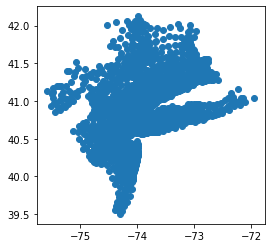

In [12]:
# Take a look at the plot

NYMetro_Tract_Geodata_Raw.plot()

This is great. I now have a geodata with the point geometry. 

In [13]:
# now, import the censeus data I have from earlier notebooks
CensusData1 = pd.read_csv('Data/Combined.csv',
                                   dtype={
                                       'AFFGEOID':str
                                   }
                                   )

In [14]:
# take a look at it.

CensusData1.head()

,AFFGEOID,Geographic Area Name,Median_Income_2014,Median_Income_2018,Median_Income_Change,Rail_Transportation_2014,Rail_Transportation_2018,Rail_Transportation_Change
0,1400000US09001010101,"Census Tract 101.01, Fairfield County, Connect...",161140,155375,-0.0358,155,274,0.7677
1,1400000US09001010102,"Census Tract 101.02, Fairfield County, Connect...",250000,250000,0.0000,150,268,0.7867
2,1400000US09001010201,"Census Tract 102.01, Fairfield County, Connect...",250000,246667,-0.0133,363,262,-0.2782
3,1400000US09001010202,"Census Tract 102.02, Fairfield County, Connect...",180184,188625,0.0468,319,480,0.5047
4,1400000US09001010300,"Census Tract 103, Fairfield County, Connecticut",197500,234625,0.1880,408,440,0.0784


In [15]:
# Clean the columns and rename them

Columns_to_keep1 = ['STATEFP','COUNTYFP','AFFGEOID','GEOID','geometry','Geographic Area Name']

NYMetro_Tract_Geodata = NYMetro_Tract_Geodata_Raw [Columns_to_keep1]

In [16]:
# create a column that contains "categorical data": if transportation by railroad increases or not

CensusData1['Rail_Change']=''

CensusData1.loc[CensusData1['Rail_Transportation_Change'] > '0' ,'Rail_Change'] = 'Increase'
CensusData1.loc[CensusData1['Rail_Transportation_Change'] < '0' ,'Rail_Change'] = 'Decrease'


In [17]:
CensusData1.head()

,AFFGEOID,Geographic Area Name,Median_Income_2014,Median_Income_2018,Median_Income_Change,Rail_Transportation_2014,Rail_Transportation_2018,Rail_Transportation_Change,Rail_Change
0,1400000US09001010101,"Census Tract 101.01, Fairfield County, Connect...",161140,155375,-0.0358,155,274,0.7677,Increase
1,1400000US09001010102,"Census Tract 101.02, Fairfield County, Connect...",250000,250000,0.0000,150,268,0.7867,Increase
2,1400000US09001010201,"Census Tract 102.01, Fairfield County, Connect...",250000,246667,-0.0133,363,262,-0.2782,Decrease
3,1400000US09001010202,"Census Tract 102.02, Fairfield County, Connect...",180184,188625,0.0468,319,480,0.5047,Increase
4,1400000US09001010300,"Census Tract 103, Fairfield County, Connecticut",197500,234625,0.1880,408,440,0.0784,Increase


In [18]:
# merge the geodata and the census data

Combined_geo = NYMetro_Tract_Geodata.merge(CensusData1,
                                          on='AFFGEOID',
                                          how='right')

In [19]:
# drop the last rows because of null geodata values

Combined_geo = Combined_geo.drop([5301,5302,5303,5304,5305,5306,5307,5308])


In [20]:
# Also, seperate x,y values into the new columns

Combined_geo['x'] = Combined_geo.geometry.x
Combined_geo['y'] = Combined_geo.geometry.y

In [21]:
# convert it to 3857 so that the map can be projected

Combined_geo_crs =  Combined_geo.to_crs(epsg=4326)

In [22]:
# take a look at it.

Combined_geo_crs.head()

,STATEFP,COUNTYFP,AFFGEOID,GEOID,geometry,Geographic Area Name_x,Geographic Area Name_y,Median_Income_2014,Median_Income_2018,Median_Income_Change,Rail_Transportation_2014,Rail_Transportation_2018,Rail_Transportation_Change,Rail_Change,x,y
0,09,001,1400000US09001010700,09001010700,POINT (-73.61489 41.03020),"Census Tract 107, Fairfield County, Connecticut","Census Tract 107, Fairfield County, Connecticut",75492,64722,-0.1427,189,270,0.4286,Increase,-73.614888,41.030201
1,09,001,1400000US09001022000,09001022000,POINT (-73.51420 41.05299),"Census Tract 220, Fairfield County, Connecticut","Census Tract 220, Fairfield County, Connecticut",55167,66250,0.2009,30,15,-0.5000,Decrease,-73.514196,41.052986
2,09,001,1400000US09001042500,09001042500,POINT (-73.40140 41.15584),"Census Tract 425, Fairfield County, Connecticut","Census Tract 425, Fairfield County, Connecticut",118984,128512,0.0801,46,182,2.9565,Increase,-73.401398,41.155844
3,09,001,1400000US09001043500,09001043500,POINT (-73.38929 41.12041),"Census Tract 435, Fairfield County, Connecticut","Census Tract 435, Fairfield County, Connecticut",93152,106964,0.1483,94,74,-0.2128,Decrease,-73.389295,41.120412
4,09,001,1400000US09001060100,09001060100,POINT (-73.24155 41.21405),"Census Tract 601, Fairfield County, Connecticut","Census Tract 601, Fairfield County, Connecticut",139211,123750,-0.1111,108,167,0.5463,Increase,-73.241549,41.214050


Now, i have a census data ready for the spatial analysis.

In [23]:
# I create a new data frame that only contains the areas that see an increase in commuters
increase_region = Combined_geo_crs[Combined_geo_crs.Rail_Change == 'Increase']

# Spatial Analysis

In this section, I will first spatially map the data of transportation by railroad so that I know where the data concentrates. Second, I will add the "bar charts" on the top and right side to show how the concentration changs across the section.

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


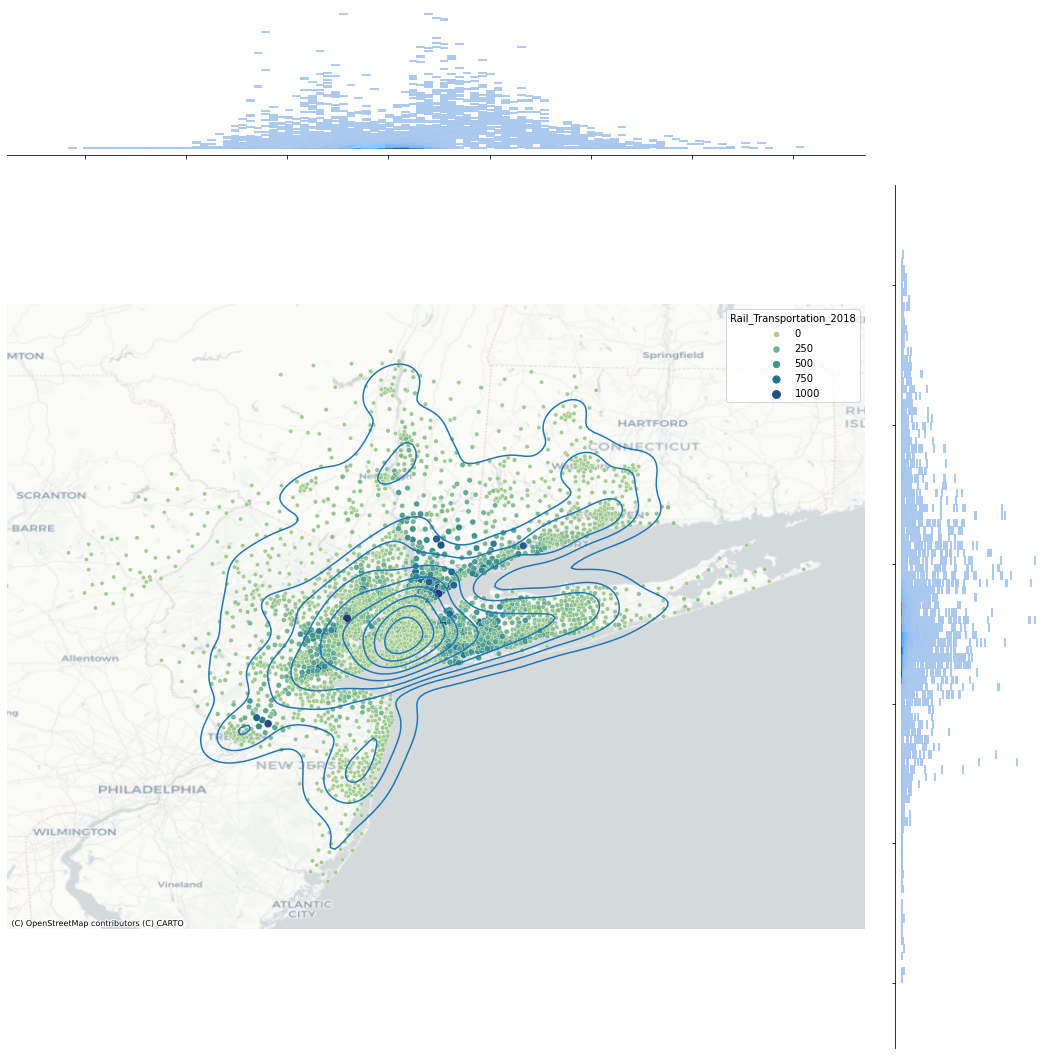

In [24]:
g = sns.JointGrid(height=15)  # create a base grid
x, y = Combined_geo_crs["x"], Combined_geo_crs["y"] # set up the basic x y coordinators


# first, add the scatter plot to show the data points of each census tracts. the size indicates the values of each data
sns.scatterplot(data=Combined_geo_crs,
            x='x', 
            y='y',
            size='Rail_Transportation_2018',
            hue='Rail_Transportation_2018',
            palette='crest',
            s=10,
            ax=g.ax_joint)

# add KDE plots to add the "counterline" to the map to show how census tracts change spatially
sns.kdeplot(y=y,
            x=x,
            linewidth=2, 
            ax=g.ax_joint)


# add top and right side bar chart to show the value of the data in relation to the x, y coordinators
sns.histplot(x=x, 
             y= Combined_geo_crs['Rail_Transportation_2018'],
             fill=False, 
             linewidth=2,
             ax=g.ax_marg_x)

sns.histplot(y=y, 
             x= Combined_geo_crs['Rail_Transportation_2018'],
             fill=False, 
             linewidth=2,
             ax=g.ax_marg_y)

#turn off the axis
g.ax_joint.set_axis_off()

# add basemap
ctx.add_basemap(ax = g.ax_joint,
               source=ctx.providers.CartoDB.Positron,
                crs='epsg:4326'
               )


Findings from the above graph:

Therefore several "spots" that the transportation ppl concentrate - those deep blue color points. And thoes people tend to cluster toegther instead of spreading out. 

Distance is not really deciding the tendency of railroad commuters - some are in far away counites. 

The following section is to compare those areas where therailroad commuters grow and the other areas where the commuters decrease.

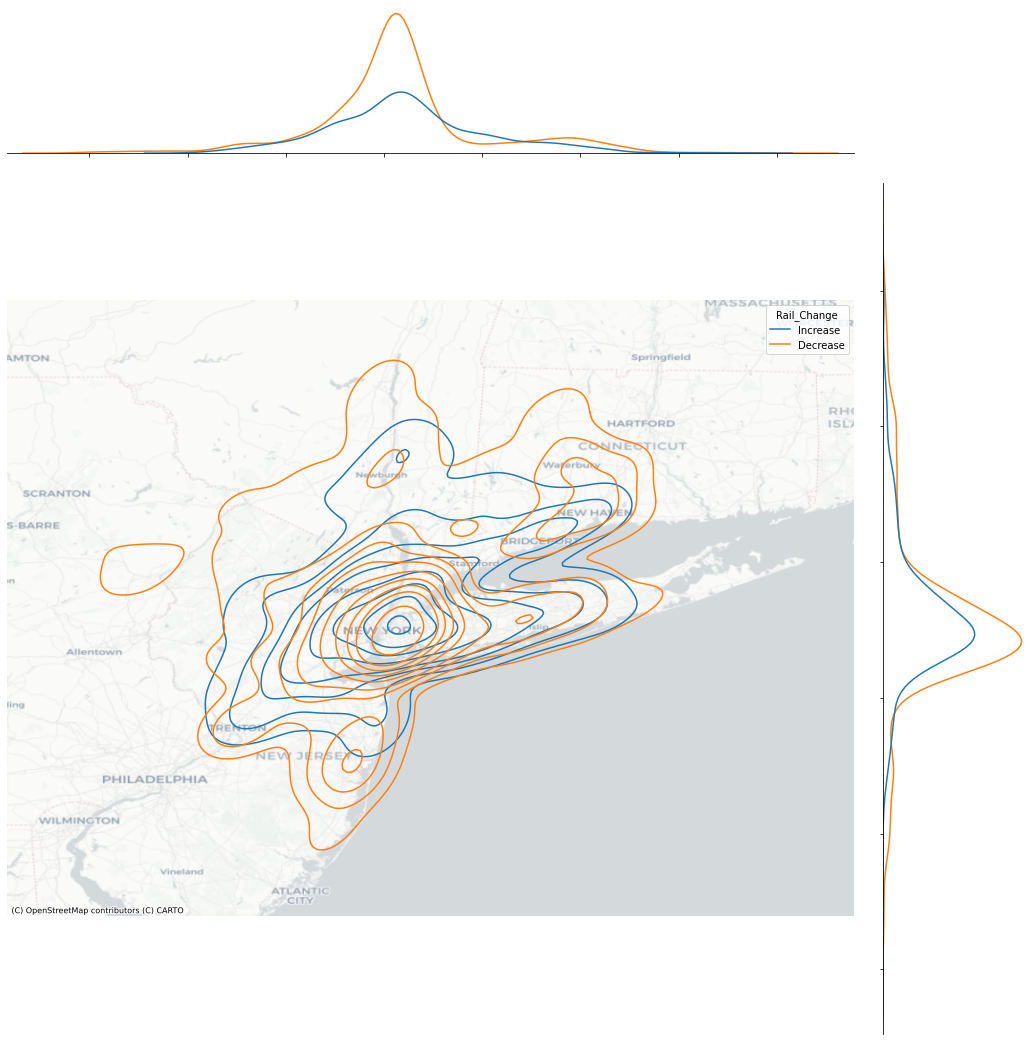

In [25]:
g = sns.jointplot(data = Combined_geo_crs,
              x='x', 
              y='y',
             hue='Rail_Change',
              kind='kde',
              height=15
                 )

g.ax_joint.set_axis_off()

ctx.add_basemap(ax = g.ax_joint,
               source=ctx.providers.CartoDB.Positron,
                crs='epsg:4326'
               )


In general, the growing commuters has a continous tendency - continous blue lines centering on the NYC.

But, the decreasing commuter zones are more discrete - there are several yellow "centers" 

now, I will be only using the data for the regions that see an increase in commuters so that I know where they concentrate

In [26]:
mean_center = centrography.mean_center(increase_region[['x','y']])
med_center = centrography.euclidean_median(increase_region[['x','y']])

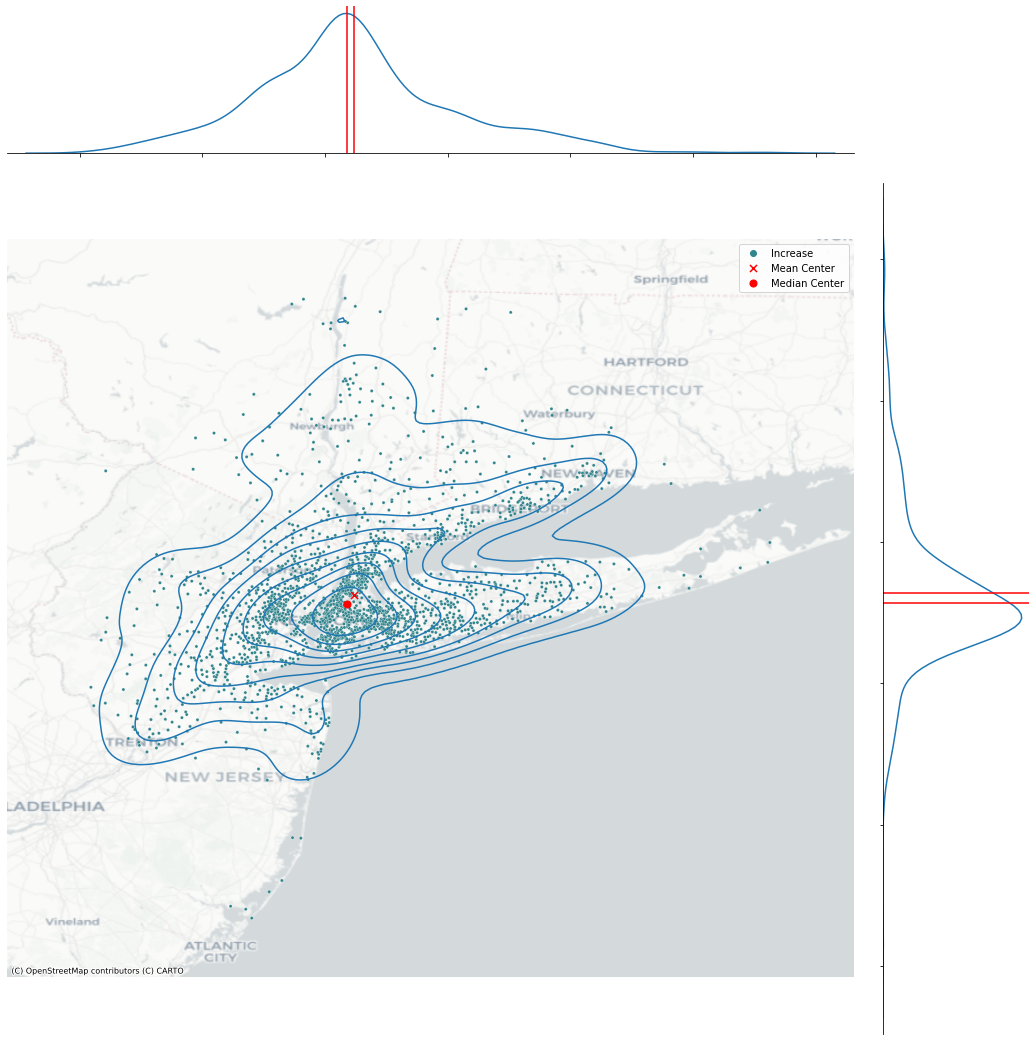

In [27]:
g = sns.jointplot(data = increase_region,
              x='x', 
              y='y', 
              kind='kde',
              height=15
                 )

ctx.add_basemap(g.ax_joint,source=ctx.providers.CartoDB.Positron,
               crs='epsg:4326')

sns.scatterplot(data=increase_region,
            x='x', 
            y='y',
            hue='Rail_Change',
            palette='crest',
            s=10,
            ax=g.ax_joint)

g.ax_joint.scatter(*mean_center, 
                   color='red', 
                   marker='x', 
                   s=50, 
                   label='Mean Center'
                  )
                  
g.ax_marg_x.axvline(mean_center[0], color='red')
g.ax_marg_y.axhline(mean_center[1], color='red')

g.ax_joint.scatter(*med_center, 
                   color='red', 
                   marker='o', 
                   s=50, 
                   label='Median Center'
                  )
                  
g.ax_marg_x.axvline(med_center[0], color='red')
g.ax_marg_y.axhline(med_center[1], color='red')

g.ax_joint.legend()

g.ax_joint.set_axis_off()

plt.show()

This graph shows where the regions with increasing commuters concentrates - in the surrounding NYC region. More important, the bar curves on the top and right indicate a relatively sharp drop - implying the incrasing commuter regions usually concentrate in the areas close to NYC.

Next, I want to how the data spreads out spatially and statistically. 

In [28]:
major, minor, rotation = centrography.ellipse(increase_region[['x','y']])

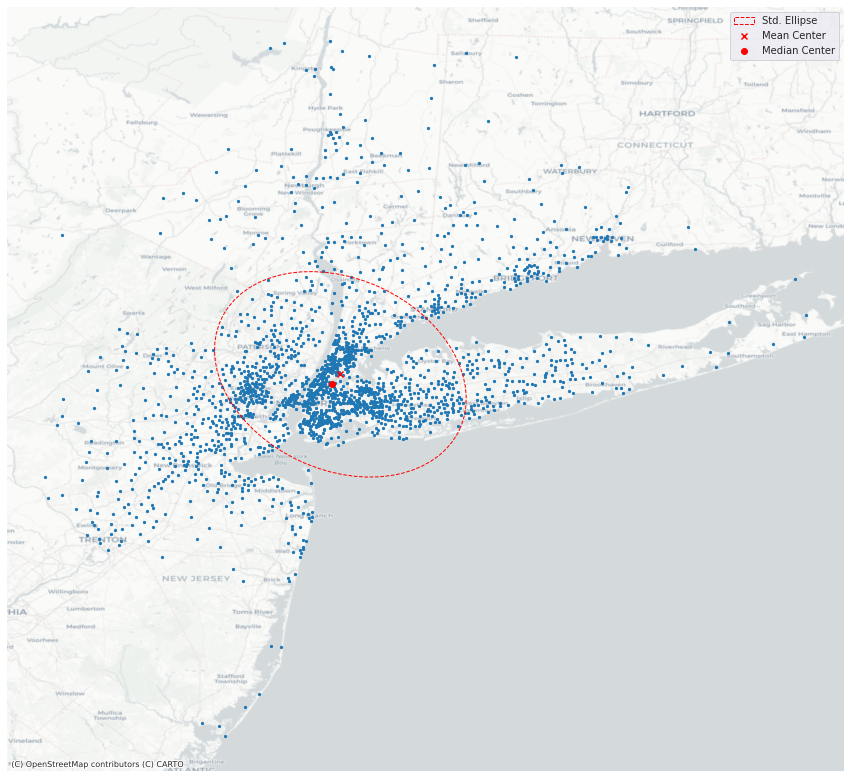

In [29]:
sns.set_style('dark')

f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(increase_region['x'], increase_region['y'], s=5)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='red', marker='o', label='Median Center')

ellipse = Ellipse(xy=mean_center, 
                  width=major*2, 
                  height=minor*2, 
                  angle = np.rad2deg(rotation), 
                  facecolor='none', 
                  edgecolor='red', 
                  linestyle='--',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

ax.axis('off')

# add a basemap
ctx.add_basemap(ax,
                source=ctx.providers.CartoDB.Positron,
               crs='epsg:4326')

# Display
plt.show()

The illustration above shows the data tends to spread out toward Long Island direction - indicating there's a greater tendency where the increasing commuters move to those regions. 

Spatially seeing the statistical analysis on the commuter patterns is really interesting. We hope to use this kind of analysis and prsentation to all factors we have used to measure the migration impacts. 
